In [1]:
from PatriciaDatabase import PatriciaDatabase
from PatriciaTrie import PatriciaTrie
from MerkleDatabase import MerkleDatabase
from MerkleTree import MerkleTree
from MerkleTreeDraw import MerkleTreeDraw
from hashfunction import get_hash
from MerkleValidate import get_nodes_for_validation

import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def generate_transaction_hash():
    ms = time.time()
    return get_hash(str(ms), simple_hash=False)

In [3]:
def generate_users(
    user_number=10**3, init_budget=10**8):
    """
    This function create users with initial budget 
    and with their transaction hash
    """
    users = []
    transactions = []
    
    for i in range(user_number):
        user = get_hash(str(i), simple_hash=False)
        users += [user]
        tx_hash = generate_transaction_hash()
        transactions += [('create', user, init_budget, tx_hash)]
        
    return users, transactions

In [4]:
def generate_transaction(users, max_spend=100):
    """
    This function create spend one transaction 
    for given users with selected randomly.
    """
    transaction = None
    
    # Random spends among users
    tx_hash = generate_transaction_hash()
    idx1, idx2 = np.random.choice(range(len(users)), size=2, replace=False)
    amount = np.random.randint(low=1, high=max_spend)
    transaction = ('spend', users[idx1], users[idx2], amount, tx_hash)
    
    return transaction

In [5]:
def update(transactions):
    """
    transactions: ('spend', user1, user2, amount, tx_hash)
                  ('create', user, budget, tx_hash)  
    |transactions| <= block_size
    """
    block = []
    block_id = db_mekrle.get_block_number() + 1
    
    for position, tx in enumerate(transactions):
        if tx[0] == 'create':
            # Update Patricia tree
            patricai_trie.create(tx[1], tx[2], tx[3])
            
            # Save user and transaction as raw information
            db_mekrle.create_user(tx[1], tx[2])
            db_mekrle.insert_trancsaction(
                txhash=tx[3], _type='create', user1=tx[1],
                amount=tx[2], blockid=block_id, position=position + 1
            )
        if tx[0] == 'spend':
            # Update Patricia tree
            patricai_trie.spend(tx[1], tx[2], tx[3], tx[4])
            
            # Save user and transaction as raw information
            db_mekrle.update_user_balance(
                tx[1], db_mekrle.get_balance_of_user(tx[1]) - tx[3]
            )
            db_mekrle.update_user_balance(
                tx[2], db_mekrle.get_balance_of_user(tx[2]) + tx[3]
            )
            db_mekrle.insert_trancsaction(
                txhash=tx[4], _type='spend', user1=tx[1], user2=tx[2],
                amount=tx[3], blockid=block_id, position=position + 1
            )
        block.append(tx[-1])

    # Create merkle tree from  block of transactions
    merkle_tree = MerkleTree(db_mekrle, block, simple_hash=False)
    merkle_root_hash = db_mekrle.get_root_info(
        block=block_id, field='merkle_hash'
    )

    # Add patricia root hash to database
    patricia_root_hash = db_patricia.get_cell('PatriciaNode', 'hash', 'node_id', 1)
    db_mekrle.update_info(
        field='patricia_hash', new_value=patricia_root_hash, idx=block_id
    )

    # Calculate block hash
    prev_block_hash = ''
    if block_id != 1:
        prev_block_hash = db_mekrle.get_root_info(
            block=block_id - 1, field='block_hash'
        )

    block_hash = get_hash(
        merkle_root_hash + patricia_root_hash + prev_block_hash,
        simple_hash=False
    )

    # Save block hash in database
    db_mekrle.update_info(
        field='block_hash', new_value=block_hash, idx=block_id
    )

In [6]:
args = {
    'DB_NAME': "darkhannurlybay", 
    'DB_USER': "darkhannurlybay",
    'DB_PASSWORD': "",
    'DB_HOST': "localhost",
    'DB_PORT': "5432",
    'verbose': False
}

### Experiments

In [7]:
def measure_balance_request(block_size, cnt):
    usual = np.zeros(cnt)
    specific = np.zeros(cnt)

    for j, user in enumerate(np.random.choice(users, size=cnt)):
        # Usual balance request
        start = time.time()
        _ = db_mekrle.get_balance_of_user(user)
        end = time.time()
        usual[j] = 1000 * (end - start)

        # Patricia balance request
        start = time.time()
        _ = patricai_trie.get_balance(user)
        end = time.time()
        specific[j] = 1000 * (end - start)
        
    TIME[block_size]['times_mean']['balance_request']['usual'].append(usual.mean())
    TIME[block_size]['times_mean']['balance_request']['specific'].append(specific.mean())
    
    TIME[block_size]['times_std']['balance_request']['usual'].append(usual.std())
    TIME[block_size]['times_std']['balance_request']['specific'].append(specific.std())

In [8]:
def measure_transaction_time(block_size, cnt):
    usual = np.zeros(cnt)
    specific = np.zeros(cnt)
    
    for j, tx in enumerate(np.random.choice(transactions, size=cnt)):
        # Usual transaction request
        start = time.time()
        _ = db_mekrle.get_trancsaction(tx)
        end = time.time()
        usual[j] = 1000 * (end - start)

        # Merkle transaction request
        start = time.time()
        transaction = db_mekrle.get_trancsaction(tx)
        nodes_for_validation = get_nodes_for_validation(
            db_mekrle, block=transaction[6], position=transaction[7]
        )
        end = time.time()
        specific[j] = 1000 * (end - start)

    TIME[block_size]['times_mean']['transaction_request']['usual'].append(usual.mean())
    TIME[block_size]['times_mean']['transaction_request']['specific'].append(specific.mean())
    
    TIME[block_size]['times_std']['transaction_request']['usual'].append(usual.std())
    TIME[block_size]['times_std']['transaction_request']['specific'].append(specific.std())

In [9]:
TIME = dict()
user_number = 100
n_iter = 2 ** 12
max_spend = 100

In [10]:
BLOCK_SIZES = [2 ** (i + 1) for i in range(6)]
experiment_frequency = 50

for block_size in BLOCK_SIZES:
    print('block_size', block_size)
    
    # Connection to database and clean all tables
    db_patricia = PatriciaDatabase(**args)
    db_patricia.delete_tables()
    db_patricia.create_tables()
    patricai_trie = PatriciaTrie(db_patricia, simple_hash=False)

    db_mekrle = MerkleDatabase(**args)
    db_mekrle.delete_tables()
    db_mekrle.create_tables()
    
    # create users
    users, transactions = generate_users(user_number=user_number)
    
    for i in range(0, len(transactions), block_size):
        update(transactions[i: i + block_size])
    
    tx_block = []
    transactions = [] # This for transaction_request
    
    TIME[block_size] = {
        'adding_time': [],
        'x_axis_adding_time': [],
        
        'memory_usage': {
            'merkle': [],
            'patricia': [],
            'usual': []
        },
        'x_axis': [],
        'times_mean': {
            'balance_request': {'usual': [], 'specific': []},
            'transaction_request': {'usual': [], 'specific': []}
        },
        'times_std': {
            'balance_request': {'usual': [], 'specific': []},
            'transaction_request':{'usual': [], 'specific': []}
        }
    }

    for i in tqdm(range(n_iter)):
        tx = generate_transaction(users, max_spend=max_spend)
        tx_block.append(tx)

        if (i + 1) % block_size == 0:
            start = time.time()
            update(tx_block)
            end = time.time()
            TIME[block_size]['adding_time'].append(1000 * (end - start) / block_size)
            TIME[block_size]['x_axis_adding_time'].append(i)
            
            for trx in tx_block:
                transactions.append(trx[-1])
            tx_block = []

        if (i + 1) % experiment_frequency == 0 and i >= block_size:
            cnt = 10
            measure_balance_request(block_size, cnt)
            measure_transaction_time(block_size, cnt)
            TIME[block_size]['memory_usage']['merkle'].append(
                db_mekrle.get_table_size('Block') + 
                db_mekrle.get_table_size('MerkleNode')
            )
            TIME[block_size]['memory_usage']['patricia'].append(
                db_patricia.get_table_size('PatriciaEdge') +
                db_patricia.get_table_size('PatriciaNode')
            )
            TIME[block_size]['memory_usage']['usual'].append(
                db_patricia.get_table_size('balance') +
                db_patricia.get_table_size('transaction')
            )
            TIME[block_size]['x_axis'].append(i)
    db_mekrle.close_session()
    db_patricia.close_session()

block_size 2


100%|██████████| 4096/4096 [05:24<00:00, 12.62it/s]


block_size 4


100%|██████████| 4096/4096 [04:54<00:00, 13.90it/s]


block_size 8


100%|██████████| 4096/4096 [04:41<00:00, 14.53it/s]


block_size 16


100%|██████████| 4096/4096 [04:49<00:00, 14.16it/s]


block_size 32


100%|██████████| 4096/4096 [04:48<00:00, 14.18it/s]


block_size 64


100%|██████████| 4096/4096 [04:53<00:00, 13.94it/s]


### Plot

In [11]:
def convert_to_numpy(dictionary):
    for key in dictionary:
        for _type in dictionary[key]:
            dictionary[key][_type] = np.array(dictionary[key][_type])

In [12]:
for block_size in TIME:
    convert_to_numpy(TIME[block_size]['times_mean'])
    convert_to_numpy(TIME[block_size]['times_std'])

Memory usage

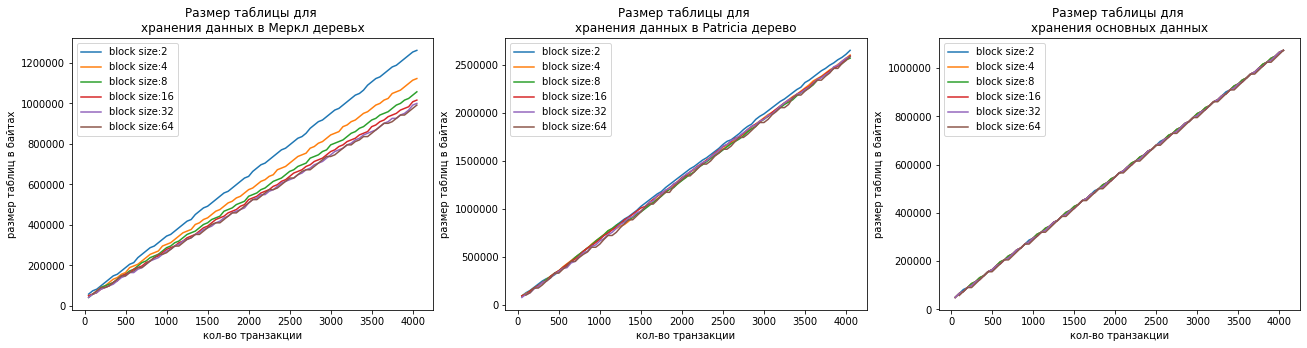

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(22, 5))
legend = []
for i in range(len(BLOCK_SIZES)):
    bs = BLOCK_SIZES[i]
    legend.append('block size:' + str(bs))
    axes[0].plot(TIME[bs]['x_axis'], TIME[bs]['memory_usage']['merkle'], '-')
    axes[1].plot(TIME[bs]['x_axis'], TIME[bs]['memory_usage']['patricia'], '-')
    axes[2].plot(TIME[bs]['x_axis'], TIME[bs]['memory_usage']['usual'], '-')
    
title = [
    'Размер таблицы для \nхранения данных в Меркл деревьх',
    'Размер таблицы для \nхранения данных в Patricia дерево',
    'Размер таблицы для \nхранения основных данных'
]
for i in range(3):
    axes[i].legend(legend);
    axes[i].set_title(title[i])
    axes[i].set_xlabel('кол-во транзакции')
    axes[i].set_ylabel('размер таблиц в байтах')
plt.show()

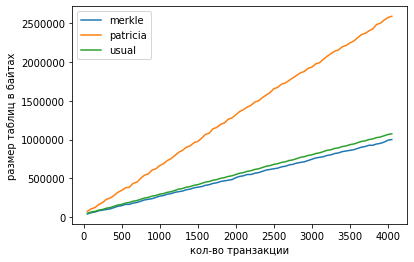

In [62]:
# plt.title('Размер таблицы для \nхранения данных. Размер блока 32',)
plt.plot(TIME[32]['x_axis'], TIME[32]['memory_usage']['merkle'], '-')
plt.plot(TIME[32]['x_axis'], TIME[32]['memory_usage']['patricia'], '-')
plt.plot(TIME[32]['x_axis'], TIME[32]['memory_usage']['usual'], '-')
plt.legend(['merkle', 'patricia', 'usual'])
plt.xlabel('кол-во транзакции')
plt.ylabel('размер таблиц в байтах');

Adding time

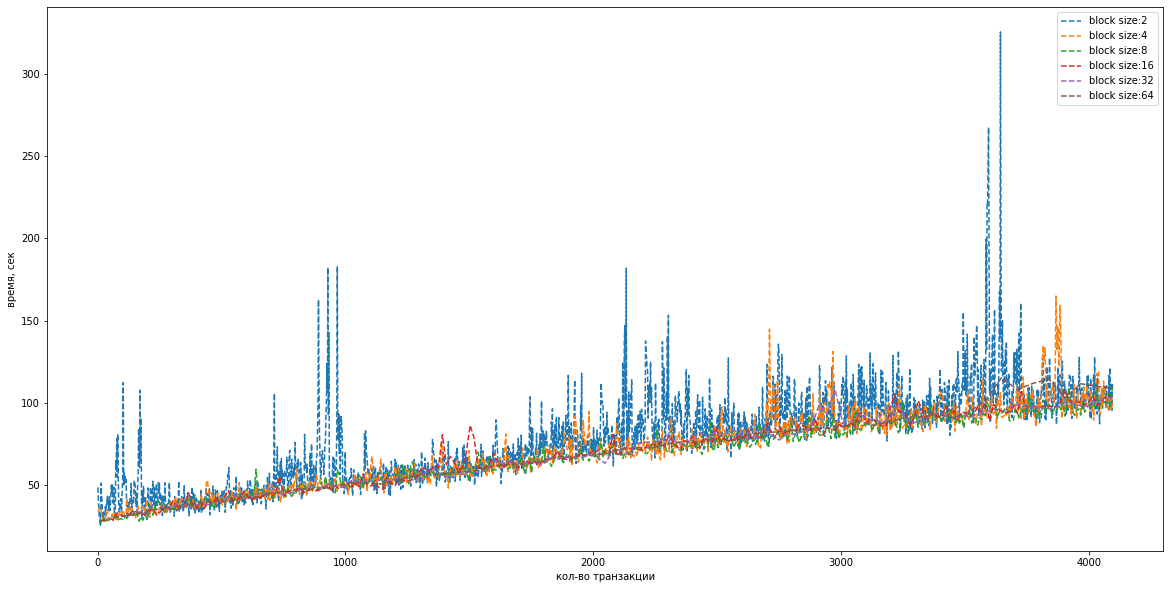

In [14]:
legend = []
plt.figure(figsize=(20,10))

for i in range(len(BLOCK_SIZES)):
    bs = BLOCK_SIZES[i]
    legend.append('block size:' + str(bs))
    plt.plot(TIME[bs]['x_axis_adding_time'], TIME[bs]['adding_time'], '--')
    
plt.legend(legend)
# plt.title('Среднее время обработки одной транзакции')
plt.xlabel('кол-во транзакции')
plt.ylabel('время, cек');

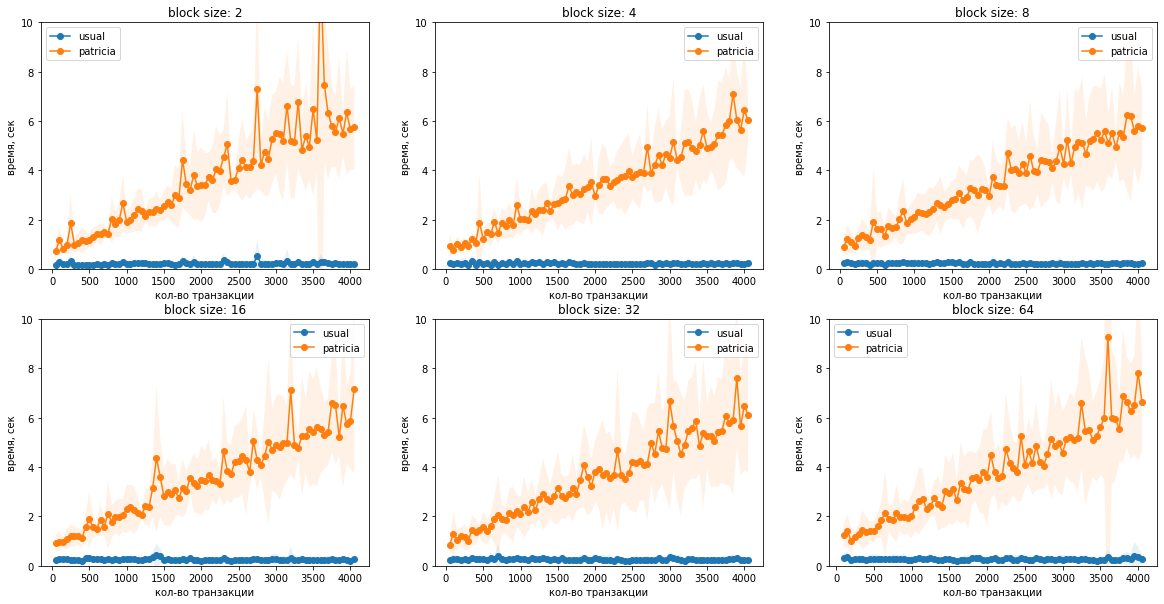

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(20, 10))

for k in range(len(BLOCK_SIZES)):
    i, j = k // 3, k % 3
    bs = BLOCK_SIZES[k]
    x = TIME[bs]['x_axis']
    
    y1 = TIME[bs]['times_mean']['balance_request']['usual']
    std1 = TIME[bs]['times_std']['balance_request']['usual']
    
    y2 = TIME[bs]['times_mean']['balance_request']['specific']
    std2 = TIME[bs]['times_std']['balance_request']['specific']
    
    axes[i, j].plot(x, y1, '-o')
    axes[i, j].plot(x, y2, '-o')
    
    
    axes[i, j].fill_between(x, y1 - 2 * std1, y1 + 2 * std1, alpha=0.1)
    axes[i, j].fill_between(x, y2 - 2 * std2, y2 + 2 * std2, alpha=0.1)
    
    axes[i, j].set_title('block size: ' + str(bs))
    axes[i, j].legend(['usual', 'patricia'])
    axes[i, j].set_xlabel('кол-во транзакции')
    axes[i, j].set_ylabel('время, сек')
    axes[i, j].set_ylim(bottom = 0, top=10)

Transaction

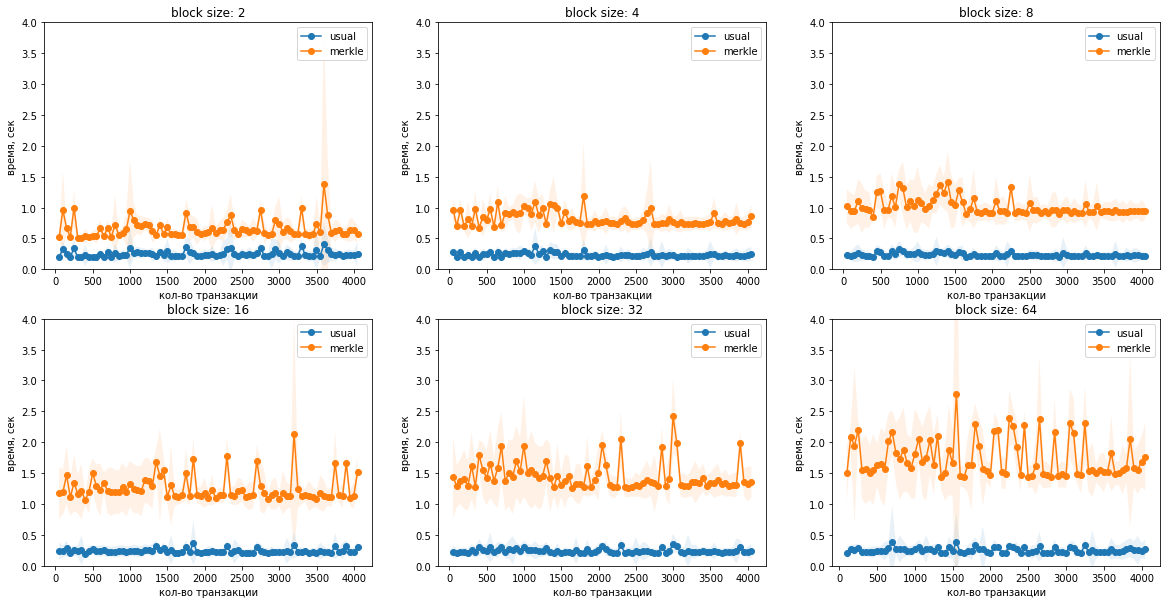

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(20, 10))

for k in range(len(BLOCK_SIZES)):
    i, j = k // 3, k % 3
    bs = BLOCK_SIZES[k]
    x = TIME[bs]['x_axis']
    
    y1 = TIME[bs]['times_mean']['transaction_request']['usual']
    std1 = TIME[bs]['times_std']['transaction_request']['usual']
    
    y2 = TIME[bs]['times_mean']['transaction_request']['specific']
    std2 = TIME[bs]['times_std']['transaction_request']['specific']
    
    axes[i, j].plot(x, y1, '-o')
    axes[i, j].plot(x, y2, '-o')
    
    
    axes[i, j].fill_between(x, y1 - 2 * std1, y1 + 2 * std1, alpha=0.1)
    axes[i, j].fill_between(x, y2 - 2 * std2, y2 + 2 * std2, alpha=0.1)
    
    axes[i, j].set_title('block size: ' + str(bs))
    axes[i, j].legend(['usual', 'merkle'])
    axes[i, j].set_xlabel('кол-во транзакции')
    axes[i, j].set_ylabel('время, сек')
    axes[i, j].set_ylim(bottom = 0, top=4)

In [28]:
y_usual = []
y_special = []
x = []
for k in range(len(BLOCK_SIZES)):
    bs = BLOCK_SIZES[k]
    x.append(bs)
    y_usual.append(TIME[bs]['times_mean']['transaction_request']['usual'].mean())
    y_special.append(TIME[bs]['times_mean']['transaction_request']['specific'].mean())

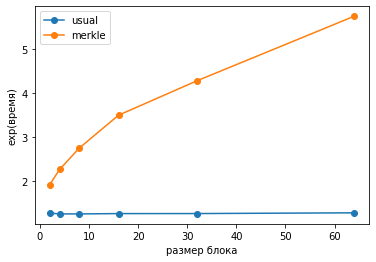

In [42]:
plt.xlabel('размер блока')
plt.ylabel('exp(время)')
plt.plot(x, np.exp(np.array(y_usual)), '-o')
plt.plot(x, np.exp(np.array(y_special)), '-o')
plt.legend(['usual', 'merkle']);